This code is following instruction from 'https://jimmy-ai.tistory.com/312'

In [17]:
%pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]3 [ipywidgets]widgets]
Note: you may need to restart the kernel to use updated packages.


In [1]:
from sklearn.datasets import fetch_openml
import torch
import numpy as np

mnist = fetch_openml('mnist_784')

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

X_train = torch.tensor(np.array(mnist.data)).float().reshape(-1, 1, 28, 28)[:60000].to(device)
y_train = torch.tensor(np.array(list(map(np.int_, mnist.target))))[:60000].to(device)

X_test = torch.tensor(np.array(mnist.data)).float().reshape(-1, 1, 28, 28)[60000:].to(device)
y_test = torch.tensor(np.array(list(map(np.int_, mnist.target))))[60000:].to(device)

print(X_train.shape) # torch.Size([60000, 1, 28, 28])
print(y_train.shape) # torch.Size([60000])

print(X_test.shape) # torch.Size([10000, 1, 28, 28])
print(y_test.shape) # torch.Size([10000])

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


/tmp/ipykernel_2783552/520253862.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  original = np.array(img_example).reshape(-1, 28).astype(int)
/tmp/ipykernel_2783552/520253862.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  aug_img = np.array(cutout_and_rotate(img_example)).reshape(-1, 28).astype(int)


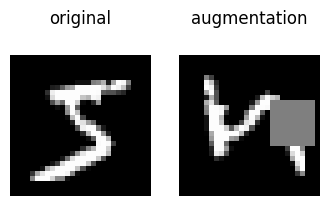

In [2]:
def cutout_and_rotate(image):
    image = image.clone().detach() # 얕은 복사 문제 주의(원본 유지)
    x_start = np.random.randint(20) # cut out 시작할 x축 위치(0~19 중 1개)
    y_start = np.random.randint(20) # cut out 시작할 y축 위치(0~19 중 1개)

    image[..., x_start:x_start+9, y_start:y_start+9] = 255 / 2 # 해당 부분 회색 마킹
    return torch.rot90(image, 1, [-2, -1]) # 마지막 두 axis 기준 90도 회전


import matplotlib.pyplot as plt
from matplotlib.pyplot import style

# 흰색 배경 및 크기 지정
style.use('default')
figure = plt.figure()
figure.set_size_inches(4, 2)

# 흑백으로 출력하기 위한 스타일 설정
style.use('grayscale')

# 1 * 2 사이즈의 격자 설정
axes = []
for i in range(1, 3):
    axes.append(figure.add_subplot(1, 2, i))

# 첫 이미지에 대한 원본 이미지 및 augmentation 수행된 이미지 시각화
img_example = X_train[0].clone().detach().cpu()
original = np.array(img_example).reshape(-1, 28).astype(int)
aug_img = np.array(cutout_and_rotate(img_example)).reshape(-1, 28).astype(int)

axes[0].matshow(original)
axes[1].matshow(aug_img)

# 제목 설정 및 눈금 제거
axes[0].set_axis_off()
axes[0].set_title('original')
axes[1].set_axis_off() 
axes[1].set_title('augmentation')

plt.show()

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1)
        self.fc = nn.Linear(4 * 4 * 20, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # (batch, 1, 28, 28) -> (batch, 10, 24, 24)

        x = F.max_pool2d(x, kernel_size=2, stride=2) # (batch, 10, 24, 24) -> (batch, 10, 12, 12)

        x = F.relu(self.conv2(x)) # (batch, 10, 12, 12) -> (batch, 20, 8, 8)

        x = F.max_pool2d(x, kernel_size=2, stride=2) # (batch, 20, 8, 8) -> (batch, 20, 4, 4)

        x = x.view(-1, 4 * 4 * 20) # (batch, 20, 4, 4) -> (batch, 320)

        x = F.relu(self.fc(x)) # (batch, 320) -> (batch, 100)
        return x # (batch, 100)

In [4]:
# 출처 : https://medium.com/the-owl/simclr-in-pytorch-5f290cb11dd7

class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    # loss 분모 부분의 negative sample 간의 내적 합만을 가져오기 위한 마스킹 행렬
    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        # loss 분자 부분의 원본 - augmentation 이미지 간의 내적 합을 가져오기 위한 부분
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [5]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

X_train_aug = cutout_and_rotate(X_train) # 각 X_train 데이터에 대하여 augmentation
X_train_aug = X_train_aug.to(device) # 학습을 위하여 GPU에 선언

dataset = TensorDataset(X_train, X_train_aug) # augmentation된 데이터와 pair
batch_size = 32

dataloader = DataLoader(
            dataset,
            batch_size = batch_size)

model = CNN()
loss_func = SimCLR_Loss(batch_size, temperature = 0.5)

# train 코드 예시
epochs = 10
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in range(1, epochs + 1):
    total_loss = 0
    for data in tqdm(dataloader):
        origin_vec = model(data[0])
        aug_vec = model(data[1])

        loss = loss_func(origin_vec, aug_vec)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch : %d, Avg Loss : %.4f'%(i, total_loss / len(dataloader)))

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 1, Avg Loss : 2.9739


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 2, Avg Loss : 2.7663


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 3, Avg Loss : 2.7214


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 4, Avg Loss : 2.6905


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 5, Avg Loss : 2.6680


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 6, Avg Loss : 2.6554


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 7, Avg Loss : 2.6470


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 8, Avg Loss : 2.6525


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 9, Avg Loss : 2.6376


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 10, Avg Loss : 2.6293


In [6]:
class CNN_classifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.CNN = model # contrastive learning으로 학습해둔 모델을 불러오기
        self.mlp = nn.Linear(100, 10) # class 차원 개수로 projection

    def forward(self, x):
        x = self.CNN(x) # (batch, 100)으로 변환
        x = self.mlp(x) # (batch, 10)으로 변환
        return x # (batch, 10)
    
class_dataset = TensorDataset(X_train, y_train) # 데이터와 라벨 간의 pair
batch_size = 32

class_dataloader = DataLoader(
            class_dataset,
            batch_size = batch_size)

In [7]:
classifier = CNN_classifier(model).to(device) # 모델 선언, GPU 활용 지정

classifier_loss = nn.CrossEntropyLoss() # 분류를 위한 loss 함수

epochs = 10
classifier.train()

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

for i in range(1, epochs + 1):
    correct = 0
    for data in tqdm(class_dataloader):
        logits = classifier(data[0])

        loss = classifier_loss(logits, data[1].long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(logits, 1) == data[1]).item() # 정확도 산출을 위하여 정답 개수 누적

    print('Epoch : %d, Train Accuracy : %.2f%%'%(i, correct * 100 / len(X_train)))

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 1, Train Accuracy : 73.68%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 2, Train Accuracy : 93.29%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 3, Train Accuracy : 96.08%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 4, Train Accuracy : 97.08%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 5, Train Accuracy : 97.64%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 6, Train Accuracy : 97.97%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 7, Train Accuracy : 98.25%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 8, Train Accuracy : 98.43%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 9, Train Accuracy : 98.59%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 10, Train Accuracy : 98.74%


In [8]:
test_dataset = TensorDataset(X_test, y_test) # 테스트 데이터와 라벨 pair
batch_size = 32

test_dataloader = DataLoader(
            test_dataset,
            batch_size = batch_size)

classifier.eval() # 테스트 모드로 전환

correct = 0
for data in tqdm(test_dataloader):

    logits = classifier(data[0])
    correct += torch.sum(torch.argmax(logits, 1) == data[1]).item() # 정확도 산출을 위하여 정답 개수 누적

print('Test Accuracy : %.2f%%'%(correct * 100 / len(X_test)))

  0%|          | 0/313 [00:00<?, ?it/s]

Test Accuracy : 98.45%
